# **Stage Zero: Data Selection** 



* Here, I will do some data analysis within the dataset. There are already 20 species here, so we good.
* I will load the metadata csv and clean it up, then do some data analysis
* From the selected species, I will then convert the audio samples into npy format to remove that step in later stages
* I will also create the two dataframes for later access. 

## Libraries

In [15]:
# Standard libraries
import numpy as np
import pandas as pd
import os
import time

# Libraries for audio
from IPython.display import Audio
import librosa

# Training and Testing Split
from sklearn.model_selection import train_test_split

# Splitting data
import tensorflow as tf

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pygame
import time
from scipy.signal import butter, filtfilt
import random
import IPython.display as ipd

import csv

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
def play_sound(file_path):
    """
    Plays the sound file specified by file_path.

    Parameters:
        file_path (str): The path to the sound file to be played.
    """
    try:
        pygame.mixer.init()
        pygame.mixer.music.load(file_path)
        pygame.mixer.music.play()
        
        # Keep the program running while the sound is playing
        while pygame.mixer.music.get_busy():
            time.sleep(1)

    except Exception as e:
        print(f"An error occurred: {e}")

# **Cleaning the dataset**

In [20]:
# Locations
path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/audio_files' # Where all the species are stored
input_file = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/raw_metadata.csv' # raw metadata
df = pd.read_csv(input_file, delimiter=';')
sr = 22050
df.head()

,species,audio_name,spectrogram_name,sec_i,sec_f
0,Acrocephalus arundinaceus,XC417157.mp3,XC417157_0.npy,2.168,3.168
1,Acrocephalus arundinaceus,XC417157.mp3,XC417157_1.npy,2.968,3.968
2,Acrocephalus arundinaceus,XC417157.mp3,XC417157_2.npy,3.768,4.768
3,Acrocephalus arundinaceus,XC417157.mp3,XC417157_3.npy,4.568,5.108
4,Acrocephalus arundinaceus,XC417157.mp3,XC417157_4.npy,19.289,20.289


In [3]:
column_delete = ['spectrogram_name', 'sec_i', 'sec_f']
filtered_df = df.copy()

In [4]:
filtered_df.drop(column_delete, axis=1, inplace=True)
filtered_df.head()

,species,audio_name
0,Acrocephalus arundinaceus,XC417157.mp3
1,Acrocephalus arundinaceus,XC417157.mp3
2,Acrocephalus arundinaceus,XC417157.mp3
3,Acrocephalus arundinaceus,XC417157.mp3
4,Acrocephalus arundinaceus,XC417157.mp3


In [5]:
filtered_df['audio_name'].value_counts()

audio_name
XC478850.mp3    401
XC440361.mp3    328
XC416749.mp3    254
XC406576.mp3    211
XC477945.mp3    177
               ... 
XC380536.mp3      1
XC380537.mp3      1
XC121174.mp3      1
XC432223.mp3      1
XC550266.mp3      1
Name: count, Length: 879, dtype: int64

### Removing the duplicates

In [6]:
md_clean = filtered_df.drop_duplicates(subset=['species', 'audio_name'], keep='first')

In [7]:
md_clean['audio_name'].value_counts()

audio_name
XC417157.mp3    1
XC528507.mp3    1
XC477749.mp3    1
XC478070.mp3    1
XC478568.mp3    1
               ..
XC396414.mp3    1
XC396416.mp3    1
XC414856.mp3    1
XC417089.mp3    1
XC97974.mp3     1
Name: count, Length: 879, dtype: int64

# Data Analysis

### Checking for class imbalance by sample size

In [9]:
counts = md_clean['species'].value_counts().reset_index()
counts.columns = ['species', 'Number']

# Sort by the 'species' column (which was formerly 'index')
counts = counts.sort_values('Number', ascending=False)

# Display the result
counts.head(20)

,species,Number
0,Himantopus himantopus,70
1,Alcedo atthis,64
2,Charadrius alexandrinus,58
3,Tachybaptus ruficollis,56
4,Botaurus stellaris,56
5,Fulica atra,55
6,Gallinula chloropus,54
7,Porphyrio porphyrio,53
8,Acrocephalus melanopogon,50
9,Ardea purpurea,43


In [10]:
np.max(counts['species'])

'Tachybaptus ruficollis'

### Checking for class imbalance by duration

In [11]:
md_clean.head()

,species,audio_name
0,Acrocephalus arundinaceus,XC417157.mp3
6,Acrocephalus arundinaceus,XC417158.mp3
28,Acrocephalus arundinaceus,XC417425.mp3
152,Acrocephalus arundinaceus,XC417722.mp3
211,Acrocephalus arundinaceus,XC419606.mp3


# **Downsampling for consistency**

Since the sample rate of the audio samples are from 48000 to 32000, I will downsample them to 22050Hz. Most bird calss are from 1kHz to 8kHz so this should give enough headroom to capture the frequency content. It coveres frequencies up to 11000Hz. THis would balance the quality of the data and the computational efficiency. 

Having a higher sampling rate adds more computational load without significant gain.

In [12]:
# Resample to 22,050 Hz and convert to mono and return the duration
def process_audio(file_path, target_sr=22050):
    try:
        # Load and resample the audio to 22,050 Hz, force mono
        y, sr = librosa.load(file_path, sr=target_sr, mono=True)
        duration = librosa.get_duration(y=y, sr=sr)
        return duration
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

In [14]:
df_filt = filtered_df.drop_duplicates(subset=['species', 'audio_name'], keep='first')
df_filt['duration'] = None

for index, row in tqdm(df_filt.iterrows(), desc="Processing data"):
    folder = row['species']
    audio_file = row['audio_name']
    file_path = os.path.join(path, folder, audio_file)
    
    # Get the sample rate and mono/stereo information
    duration = process_audio(file_path)
    
    # Update the dataframe with this informatio
    df_filt.at[index, 'duration'] = duration
df_filt.head()

C:\Users\thato\AppData\Local\Temp\ipykernel_24448\1788229051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['duration'] = None
Processing data: 879it [01:08, 12.87it/s]

An error occurred: name 'pygame' is not defined


,species,audio_name,duration
0,Acrocephalus arundinaceus,XC417157.mp3,23.244989
6,Acrocephalus arundinaceus,XC417158.mp3,62.077007
28,Acrocephalus arundinaceus,XC417425.mp3,129.032925
152,Acrocephalus arundinaceus,XC417722.mp3,89.004989
211,Acrocephalus arundinaceus,XC419606.mp3,46.692018


In [17]:
df_filt = df_filt.reset_index(drop=True)
play_sound('sound.wav')
df_filt.head()


,species,audio_name,duration
0,Acrocephalus arundinaceus,XC417157.mp3,23.244989
1,Acrocephalus arundinaceus,XC417158.mp3,62.077007
2,Acrocephalus arundinaceus,XC417425.mp3,129.032925
3,Acrocephalus arundinaceus,XC417722.mp3,89.004989
4,Acrocephalus arundinaceus,XC419606.mp3,46.692018


In [18]:
duration_sum = df_filt.groupby('species', as_index=False)['duration'].sum()
duration_sum['duration_mins'] = duration_sum['duration'] / 60
duration_sum = duration_sum.sort_values('duration', ascending=False)
duration_sum.head(20)

,species,duration,duration_mins
0,Acrocephalus arundinaceus,5199.705215,86.661754
2,Acrocephalus scirpaceus,3969.428617,66.157144
1,Acrocephalus melanopogon,3594.175283,59.902921
12,Dendrocopos minor,3594.085034,59.901417
15,Himantopus himantopus,2989.731791,49.828863
7,Botaurus stellaris,2865.786349,47.763106
17,Motacilla flava,2243.320907,37.388682
19,Tachybaptus ruficollis,2031.903084,33.865051
3,Alcedo atthis,2025.260045,33.754334
16,Ixobrychus minutus,1636.590476,27.276508


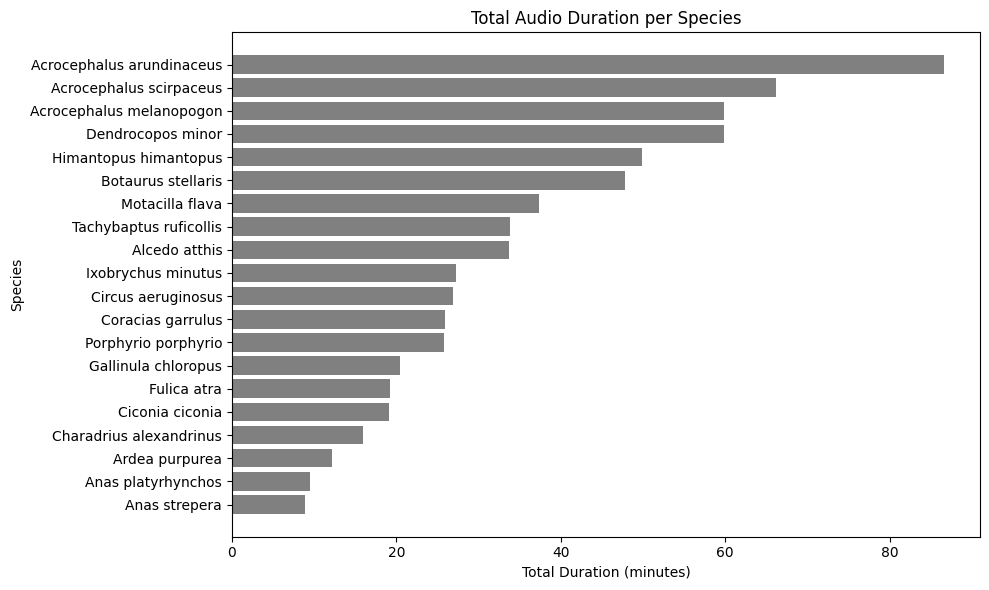

In [19]:
plt.figure(figsize=(10, 6))
plt.barh(duration_sum['species'], duration_sum['duration_mins'], color='gray')

plt.xlabel('Total Duration (minutes)')
plt.ylabel('Species')
plt.title('Total Audio Duration per Species')
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()

# **Splitting into training and testing**

In [21]:
shuffled_df = df_filt.sample(frac=1, random_state=1303) # shuffle the original df before splitting to train/test

In [22]:
train, test = train_test_split(shuffled_df, test_size=0.3, random_state=2014) # FOR REproducibility

## Extracting the numpy arrays

In [24]:
# Function to load audio, downsample it and turn it to mono
def extract_audio(filename, sr=sr):
  filepath = path + filename
  audio, _ = librosa.load(filepath, sr=sr, mono=True)
  return audio

In [25]:
# Function to save the audio as np arrays
def save_audio_np(df, is_train):
    folder_dir = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/train_audio_npy/' if is_train else 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/test_audio_npy/'
    os.makedirs(folder_dir, exist_ok=True)  # Use exist_ok=True to avoid errors if the folder exists
    filepaths = []

    # Loop over the filenames, extract the np objects, and save them to the respective directory
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Saving audio files", unit="file"):
        folder = row['species']
        name = row['audio_name']
        audio = extract_audio(f'/{folder}/{name}')
        new_filename = name.replace('.mp3', '.npy')
        filepaths.append(f'{folder}/{new_filename}')

        # Create save directory
        save_dir = f'{folder_dir}/{folder}/'
        os.makedirs(save_dir, exist_ok=True)
        save_filename = f'{save_dir}{new_filename}'

        # Check if the file already exists
        if os.path.exists(save_filename):
            print(f"File {save_filename} already exists. Skipping...")
            continue  # Skip the current iteration if the file exists

        # Save .npy object
        np.save(save_filename, audio)

    # Assert all filenames have been looped through, and all files have been saved
    assert len(df) == len(filepaths)
    return filepaths

In [26]:
train_filepaths = save_audio_np(train, is_train=True)
train['filename_npy'] = train_filepaths # Adding new column with the location of the npy filepaths
play_sound('sound.wav')

Saving audio files: 100%|██████████| 615/615 [00:45<00:00, 13.46file/s]


In [27]:
train.head()

,species,audio_name,duration,filename_npy
385,Ciconia ciconia,XC171088.mp3,32.470204,Ciconia ciconia/XC171088.npy
154,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy
626,Himantopus himantopus,XC154289.mp3,30.484898,Himantopus himantopus/XC154289.npy
744,Motacilla flava,XC281358.mp3,30.746122,Motacilla flava/XC281358.npy
60,Acrocephalus melanopogon,XC406576.mp3,202.44898,Acrocephalus melanopogon/XC406576.npy


In [28]:
test_filepaths = save_audio_np(test, is_train=False)
test['filename_npy'] = test_filepaths # Adding new column with the location of the npy filepaths
play_sound('sound.wav')

Saving audio files: 100%|██████████| 264/264 [00:18<00:00, 14.34file/s]


In [30]:
train = train.reset_index(drop=True)
train.head()

,species,audio_name,duration,filename_npy
0,Ciconia ciconia,XC171088.mp3,32.470204,Ciconia ciconia/XC171088.npy
1,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy
2,Himantopus himantopus,XC154289.mp3,30.484898,Himantopus himantopus/XC154289.npy
3,Motacilla flava,XC281358.mp3,30.746122,Motacilla flava/XC281358.npy
4,Acrocephalus melanopogon,XC406576.mp3,202.44898,Acrocephalus melanopogon/XC406576.npy


In [31]:
test = test.reset_index(drop=True)
test.head()

,species,audio_name,duration,filename_npy
0,Acrocephalus scirpaceus,XC421435.mp3,9.247347,Acrocephalus scirpaceus/XC421435.npy
1,Tachybaptus ruficollis,XC459394.mp3,7.78449,Tachybaptus ruficollis/XC459394.npy
2,Fulica atra,XC543771.mp3,3.059002,Fulica atra/XC543771.npy
3,Coracias garrulus,XC318427.mp3,760.058776,Coracias garrulus/XC318427.npy
4,Circus aeruginosus,XC100621.mp3,18.84,Circus aeruginosus/XC100621.npy


In [32]:
train.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/train-not-annotated.csv')
test.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/test-not-annotated.csv')

# **Adding Annotations**

so the dataset that i have of the different bird calls is annotated. So if the audio fileis XC417157.mp3, the accompanying annotation file is XC417157.txt. The text file has the follwing structure:

0.463875	0.634419	call

1.664493	1.828211	call

4.618285	4.829759	call

5.982623	6.166795	call

7.797193	7.947283	call

Where its annotating which parts of the audio contain actual bird calls or songs in seconds.

So its Start | End | Type

In [33]:
train

,species,audio_name,duration,filename_npy
0,Ciconia ciconia,XC171088.mp3,32.470204,Ciconia ciconia/XC171088.npy
1,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy
2,Himantopus himantopus,XC154289.mp3,30.484898,Himantopus himantopus/XC154289.npy
3,Motacilla flava,XC281358.mp3,30.746122,Motacilla flava/XC281358.npy
4,Acrocephalus melanopogon,XC406576.mp3,202.44898,Acrocephalus melanopogon/XC406576.npy
...,...,...,...,...
610,Anas platyrhynchos,XC207216.mp3,133.198367,Anas platyrhynchos/XC207216.npy
611,Dendrocopos minor,XC500751.mp3,47.857415,Dendrocopos minor/XC500751.npy
612,Alcedo atthis,XC489350.mp3,2.002404,Alcedo atthis/XC489350.npy
613,Ciconia ciconia,XC538423.mp3,52.09619,Ciconia ciconia/XC538423.npy


In [34]:
# Function to read the annotation file
def read_annotation_file(annotation_path):
    annotations = []
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:  # Ensure that we have 3 parts
                start, end, label = parts
                annotations.append({'start': float(start), 'end': float(end), 'label': label})
    return annotations

In [36]:
# Function to annotate the DataFrame
def annotate_dataframe(df, base_audio_dir):
    annotation_data = []
    
    for index, row in df.iterrows():
        species = row['species']
        audio_name = row['audio_name']
        
        # Construct the path to the annotation file
        audio_folder = os.path.join(base_audio_dir, species)
        annotation_file_path = os.path.join(audio_folder, audio_name.replace('.mp3', '.txt'))
        
        if os.path.exists(annotation_file_path):
            annotations = read_annotation_file(annotation_file_path)
            # Append annotations to the audio information
            for annotation in annotations:
                annotation_data.append({
                    'species': species,
                    'audio_name': audio_name,
                    'duration': row['duration'],
                    'filename_npy': row['filename_npy'],
                    **annotation  # Unpack start, end, and label into the dict
                })

    annotation_df = pd.DataFrame(annotation_data)
    return annotation_df

In [37]:
train_annotated_df = annotate_dataframe(train, path)

In [38]:
train_annotated_df.head(20)

,species,audio_name,duration,filename_npy,start,end,label
0,Ciconia ciconia,XC171088.mp3,32.470204,Ciconia ciconia/XC171088.npy,11.021315,16.283807,clapping
1,Ciconia ciconia,XC171088.mp3,32.470204,Ciconia ciconia/XC171088.npy,19.004347,27.850152,clapping
2,Ciconia ciconia,XC171088.mp3,32.470204,Ciconia ciconia/XC171088.npy,28.105281,29.315961,clapping
3,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy,1.875801,3.946005,call
4,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy,4.429412,4.707893,call
5,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy,5.406720,5.816561,call
6,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy,6.820139,7.072361,call
7,Alcedo atthis,XC503772.mp3,9.195102,Alcedo atthis/XC503772.npy,7.634562,7.897283,call
8,Himantopus himantopus,XC154289.mp3,30.484898,Himantopus himantopus/XC154289.npy,1.306496,12.019761,call
9,Himantopus himantopus,XC154289.mp3,30.484898,Himantopus himantopus/XC154289.npy,17.419942,25.433116,call


In [39]:
train_annotated_df['species'].value_counts()

species
Dendrocopos minor            378
Alcedo atthis                374
Ixobrychus minutus           374
Acrocephalus arundinaceus    339
Motacilla flava              326
Botaurus stellaris           281
Fulica atra                  276
Charadrius alexandrinus      245
Gallinula chloropus          216
Circus aeruginosus           201
Himantopus himantopus        196
Acrocephalus melanopogon     179
Coracias garrulus            179
Ardea purpurea               164
Porphyrio porphyrio          161
Ciconia ciconia               96
Acrocephalus scirpaceus       90
Tachybaptus ruficollis        89
Anas strepera                 76
Anas platyrhynchos            38
Name: count, dtype: int64

In [40]:
train_annotated_df.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/train-annotated.csv')

In [41]:
test_annotated_df = annotate_dataframe(test, path)

In [42]:
test_annotated_df.to_csv('C:/Users/thato/Documents/Final-Year-Project/Dataset/Project-V4/test-annotated.csv')